### Hyperparameter definition

In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join('..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
    
from clearml import Task, Logger
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, Dataset
from diffusers import AutoencoderKL, DDPMScheduler, UNet2DConditionModel, StableDiffusionPipeline
from diffusers.optimization import get_scheduler
import subprocess
import torch

from src.utils import get_free_gpu, visualize_image, collate_fn, generate_prior_preservation_samples
from src.data import PriorClassDataset

In [2]:
# Initialize ClearML Task
task = Task.init(project_name='DreamBooth Training', task_name='dreambooth_dog', reuse_last_task_id=False)
logger = Logger.current_logger()

# Define hyperparameters with additional parameters
hyperparameters = {
    'subject_tokens': 'xon',
    'subject_prompt': 'a xon dog',
    'class_prompt': 'a dog',
    'num_prior_images': 1000,
    'learning_rate': 2e-6,
    'num_train_epochs': 101,
    'prior_batch_size': 5,
    'train_batch_size': 5,
    'use_prior_preservation': True,
    'generate_prior_images' : False,
    'prior_loss_weight': 1,
    'use_dreambooth_prompts': True,
    'image_dir': '../data/paper_dataset/dog',
    'use_scheduler': True,
    'save_model': False,
    'DDPMS_num_train_timestep': 1000,
    'model_name': "CompVis/stable-diffusion-v1-4",
    'tokenizer_name': "openai/clip-vit-base-patch32",
}

# Connect hyperparameters to ClearML
task.connect(hyperparameters)

# Unpack parameters directly from dict for cleaner code
subject_prompt = hyperparameters['subject_prompt']
class_prompt = hyperparameters['class_prompt']

ClearML Task: created new task id=6f5eb20aebf4437c9287b85364badbb8
2025-03-26 16:20:25,210 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/0009581d19764aeaa42308fae5caaa27/experiments/6f5eb20aebf4437c9287b85364badbb8/output/log


### Data loading

In [3]:
tokenizer = CLIPTokenizer.from_pretrained(hyperparameters['tokenizer_name'])
text_encoder = CLIPTextModel.from_pretrained(hyperparameters['model_name'], subfolder="text_encoder")

In [4]:
# Define image transformations
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

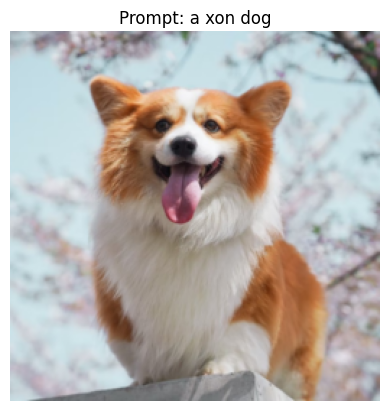

In [5]:
dataset = PriorClassDataset(hyperparameters['image_dir'], subject_prompt, class_prompt, tokenizer, train_transforms, use_dreambooth_prompts=hyperparameters['use_dreambooth_prompts'])
# Visualize the first image in the dataset
visualize_image(dataset, 0)

In [6]:
train_dataloader = DataLoader(
    dataset,
    shuffle=True,
    collate_fn=collate_fn,
    batch_size=hyperparameters['train_batch_size'],
)

### Load the diffusion model for tuning

In [7]:
pretrained_model_name_or_path = hyperparameters['model_name']
revision = None
variant = None

noise_scheduler = DDPMScheduler.from_pretrained(pretrained_model_name_or_path, num_train_timesteps=hyperparameters['DDPMS_num_train_timestep'], subfolder="scheduler")
vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae", revision=revision, variant=variant)
unet = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder="unet", revision=revision, variant=variant)

In [8]:
if torch.cuda.is_available() and torch.cuda.device_count() > 1:
    free_gpu = get_free_gpu()
    device = torch.device(f"cuda:{free_gpu}")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weight_dtype = torch.float32

unet.to(device, dtype=weight_dtype)
vae.to(device, dtype=weight_dtype)
text_encoder.to(device, dtype=weight_dtype)

CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 768)
      (position_embedding): Embedding(77, 768)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), ep

### Set Up Prior Preservation Mechanism

In [9]:
if hyperparameters['use_prior_preservation'] and hyperparameters['generate_prior_images']:
    
    # Define the save path for prior preservation samples
    save_path = '../data/prior_imgs/dog_updated'
    
    # Call the updated function to generate prior preservation samples
    prior_latents_tensor, prior_embeddings, prior_attention_mask = generate_prior_preservation_samples(
        pretrained_model_name_or_path=pretrained_model_name_or_path,
        revision=revision,
        variant=variant,
        device=device,
        weight_dtype=weight_dtype,
        vae=vae,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        noise_scheduler=noise_scheduler,
        num_prior_images=hyperparameters['num_prior_images'],
        class_prompt=class_prompt,
        train_transforms=train_transforms,
        batch_size=64,
        num_inference_steps=50,
        guidance_scale=7.5,
        save_path=save_path
    )

### Set Up Training Hyperparameters & Optimizer

In [10]:
optimizer = torch.optim.AdamW(
    list(unet.parameters()) + list(text_encoder.parameters()),
    lr=hyperparameters['learning_rate'],
    betas=(0.9, 0.999),
    weight_decay=1e-2,
    eps=1e-08,
)

In [11]:
# Use total steps based on dataset size (using custom_dataset length)
if hyperparameters['use_scheduler']:
    num_training_steps = hyperparameters['num_train_epochs'] * len(dataset) // hyperparameters['train_batch_size']
    lr_scheduler = get_scheduler(
    "constant",
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=num_training_steps,
    )

### Set up the prior_dataloader

In [12]:
# Load the tensor from the file
prior_latents_tensor = torch.load('../data/prior_imgs/dog_updated/prior_latents_tensor.pt')
prior_embeddings = torch.load('../data/prior_imgs/dog_updated/prior_embeddings.pt')
prior_attention_mask = torch.load('../data/prior_imgs/dog_updated/prior_attention_mask.pt')

2025-03-26 16:20:34,172 - clearml.model - INFO - Selected model id: 83ef8c1515d2467eb56b845b4f8a6d97
2025-03-26 16:20:37,562 - clearml.model - INFO - Selected model id: 828d82e4e7fc45018a7cf82e5052fdde
2025-03-26 16:20:40,931 - clearml.model - INFO - Selected model id: cfab65ab62db45b3af0a68410b0ce66d


In [13]:
prior_dataset = TensorDataset(prior_latents_tensor)
prior_dataloader = DataLoader(prior_dataset, batch_size=hyperparameters['prior_batch_size'], shuffle=True)

### Model tuning

In [14]:
pipeline = StableDiffusionPipeline(
    vae=vae,
    text_encoder=text_encoder,
    tokenizer=tokenizer,
    unet=unet,
    scheduler=noise_scheduler,
    safety_checker=None,
    feature_extractor=None,
)
pipeline = pipeline.to(device)

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


In [15]:
device

device(type='cuda', index=1)

In [16]:
# Training Loop with Dual (Subject + Prior) Losses
for epoch in tqdm(range(hyperparameters['num_train_epochs']), desc="Epochs"):
    unet.train()
    text_encoder.train()
    epoch_losses = []

    prior_iter = iter(prior_dataloader)

    for index, batch in enumerate(tqdm(train_dataloader, desc="Batches", leave=False)):
        # Move subject batch to device.
        pixel_values = batch["pixel_values"].to(dtype=weight_dtype, device=device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        # Convert subject images to latent space.
        latents = vae.encode(pixel_values).latent_dist.sample() * vae.config.scaling_factor

        # Sample noise and timesteps for subject images.
        noise = torch.randn_like(latents, device=device)
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, 
                                  (latents.shape[0],), device=device).long()
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Get text embeddings from subject prompts.
        outputs = text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state

        # Predict noise residual for subject branch.
        model_pred = unet(noisy_latents, timesteps, encoder_hidden_states=embeddings,
                          encoder_attention_mask=attention_mask, return_dict=False)[0]
        loss_subject = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

        # ----- Prior Preservation Loss -----
        if hyperparameters['use_prior_preservation']:
            
            try:
                prior_batch = next(prior_iter)[0].to(device=device, dtype=weight_dtype)
            except StopIteration:
                prior_iter = iter(prior_dataloader)
                prior_batch = next(prior_iter)[0].to(device=device, dtype=weight_dtype)

            # For the prior branch, sample noise and timesteps.
            noise_prior = torch.randn_like(prior_batch, device=device)
            t_prior = torch.randint(0, noise_scheduler.config.num_train_timesteps, 
                                      (prior_batch.shape[0],), device=device).long()
            noisy_prior_latents = noise_scheduler.add_noise(prior_batch, noise_prior, t_prior)

            # Make sure prior embeddings and attention mask are on the same device
            if prior_embeddings.device != device:
                prior_embeddings = prior_embeddings.to(device)
            if prior_attention_mask.device != device:
                prior_attention_mask = prior_attention_mask.to(device)
                
            # Expand prior embeddings to match batch size.
            prior_embeddings_expanded = prior_embeddings.expand(noisy_prior_latents.shape[0], -1, -1)
            prior_attention_mask_expanded = prior_attention_mask.expand(noisy_prior_latents.shape[0], -1)

            # Predict noise residual for prior branch.
            model_pred_prior = unet(noisy_prior_latents, t_prior, encoder_hidden_states=prior_embeddings_expanded,
                                    encoder_attention_mask=prior_attention_mask_expanded, return_dict=False)[0]
            loss_prior = F.mse_loss(model_pred_prior.float(), noise_prior.float(), reduction="mean")
        
        else:
            loss_prior = 0.0

        # Total loss is the sum of subject loss and weighted prior loss.
        loss = loss_subject + hyperparameters['prior_loss_weight'] * loss_prior

        optimizer.zero_grad()  
        loss.backward()  
        optimizer.step()  
        
        if hyperparameters['use_scheduler']:
            lr_scheduler.step() 

        epoch_losses.append(loss.item())

    avg_loss = sum(epoch_losses) / len(epoch_losses)
    
    # Log metrics
    logger.report_scalar(
        title="Training Metrics", 
        series="Loss", 
        value=avg_loss, 
        iteration=epoch
    )
    if hyperparameters['use_scheduler']:
        logger.report_scalar(
        title="Training Metrics",
        series="Learning Rate",
        value=lr_scheduler.get_last_lr()[0],
        iteration=epoch
        )
    
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch + 1}/{hyperparameters['num_train_epochs']}, Loss: {avg_loss:.4f}")
    # Periodic image generation and logging
    if epoch % 100 == 0:
        with torch.no_grad():
            test_image = pipeline(subject_prompt, num_inference_steps=100).images[0]
            logger.report_image(
                title="Sample Outputs",
                series=f"Epoch {epoch}",
                image=test_image,
                iteration=epoch
            )

Epochs:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch 1/101, Loss: 0.8600


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs:  99%|█████████▉| 100/101 [00:57<00:00,  1.95it/s]

Epoch 101/101, Loss: 0.2565


  0%|          | 0/100 [00:00<?, ?it/s]

Epochs: 100%|██████████| 101/101 [01:05<00:00,  1.54it/s]


### Inference: Generate Images using the Fine-Tuned Model

In [17]:
unet.eval()
text_encoder.eval()
vae.eval()

AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0-1): 2 x ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
        )
        (downsamplers): ModuleList(
          (0): Downsample2D(
            (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
          )
        )
      )
      (1): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (c

### Check only the subject_prompt without additional stylization

In [18]:
# Final image logging
prompt = subject_prompt
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    logger.report_image(
        title="Final Outputs",
        series=f"Image {idx}",
        image=img,
        iteration=hyperparameters['num_train_epochs']
    )

  0%|          | 0/100 [00:00<?, ?it/s]

In [19]:
task.close()

Prompt: a xon dog


  0%|          | 0/100 [00:00<?, ?it/s]

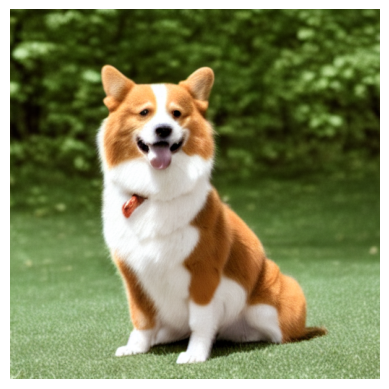

In [20]:
prompt = subject_prompt
print(f"Prompt: {prompt}")
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    # img.save(f"target_generated_image_{idx}.png")

### Check the subject_prompt with additional stylization

Prompt: sad a xon dog


  0%|          | 0/100 [00:00<?, ?it/s]

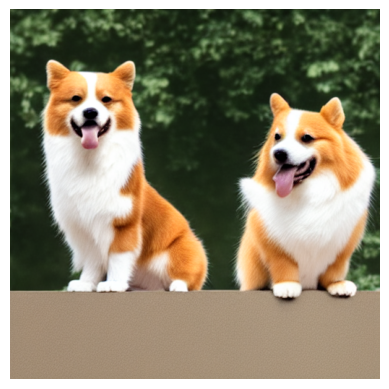

In [21]:
prompt = "sad " + subject_prompt
print(f"Prompt: {prompt}")
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    # img.save(f"styled_generated_image_{0}.png")


Prompt: a xon dog in astronaut costume against moon and stars. The xon dog stands proudly on the rocky lunar surface, with its paw slightly raised as if exploring.


  0%|          | 0/100 [00:00<?, ?it/s]

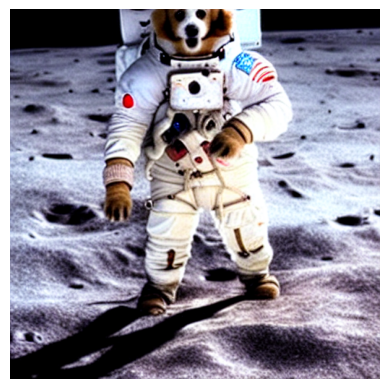

In [30]:
prompt = subject_prompt + " in astronaut costume against moon and stars. The xon dog stands proudly on the rocky lunar surface, with its paw slightly raised as if exploring."
print(f"Prompt: {prompt}")
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=7.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    # img.save(f"styled_generated_image_{1}.png")


Prompt: a xon dog in cool sunglasses sitting in the sport car, smillings and have good time


  0%|          | 0/100 [00:00<?, ?it/s]

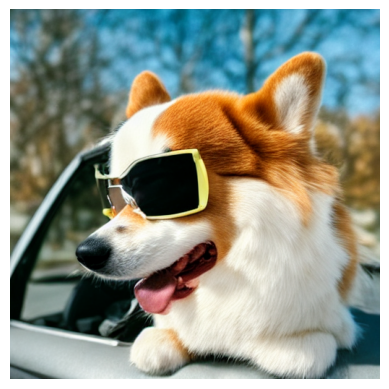

In [23]:
prompt = subject_prompt + " in cool sunglasses sitting in the sport car, smillings and have good time"
print(f"Prompt: {prompt}")
with torch.autocast(device.type):
    images = pipeline(prompt, num_inference_steps=100, guidance_scale=4.5).images

for idx, img in enumerate(images):
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    # img.save(f"styled_generated_image_{2}.png")


In [ ]:
if hyperparameters['save_model']:
    model_dir = '../data/models/challenger'
    pipeline.save_pretrained(model_dir)